In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Exploring the Dataset

In [21]:
df_cancer = pd.read_csv("pollution_cancer.csv")
df_cancer.head()

,County,Year,Deaths,Crude Rate,Age Adjusted Rate,Days_PM25_fraction,Unhealthy_fraction,VeryUnhealthy_fraction,Hazardous_fraction,Max_AQI,Median_AQI
0,"Baldwin County, AL",2000.0,98.0,69.8,58.8,0.198444,0.038911,0.003891,0.0,205,55
1,"Baldwin County, AL",2001.0,113.0,78.0,63.9,0.282686,0.007067,0.000000,0.0,159,46
2,"Baldwin County, AL",2002.0,112.0,75.7,61.0,0.327338,0.000000,0.000000,0.0,105,43
3,"Baldwin County, AL",2003.0,115.0,75.9,60.8,0.359712,0.003597,0.000000,0.0,174,45
4,"Baldwin County, AL",2004.0,126.0,80.6,63.0,0.317343,0.000000,0.000000,0.0,143,46


In [23]:
df_year_count = df_cancer.groupby("Year").size().reset_index(name="count")
print(df_year_count)

      Year  count
0   1999.0    850
1   2000.0    896
2   2001.0    915
3   2002.0    915
4   2003.0    909
5   2004.0    908
6   2005.0    917
7   2006.0    893
8   2007.0    891
9   2008.0    889
10  2009.0    877
11  2010.0    886
12  2011.0    887
13  2012.0    860
14  2013.0    854
15  2014.0    842
16  2015.0    856
17  2016.0    852
18  2017.0    846
19  2018.0    838
20  2019.0    831
21  2020.0    801


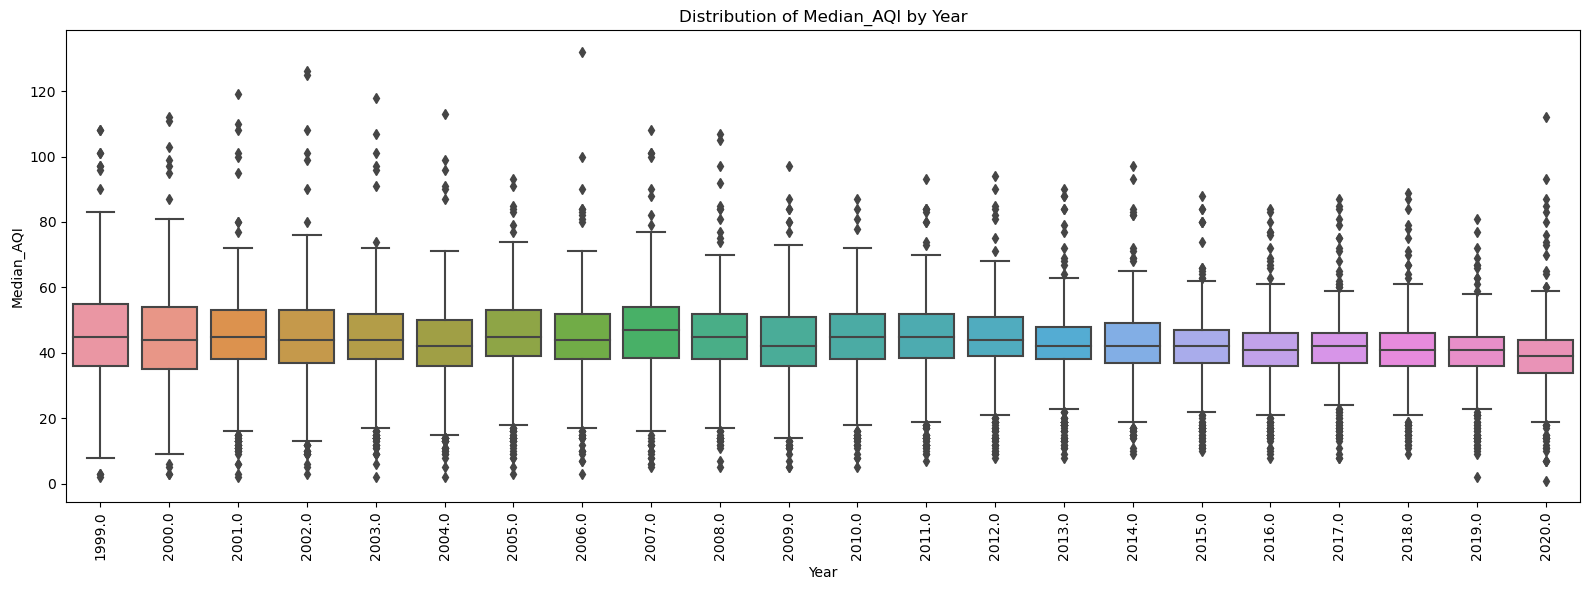

In [33]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_cancer, x="Year", y="Median_AQI")

plt.xticks(rotation=90)  
plt.title("Distribution of Median_AQI by Year")
plt.xlabel("Year")
plt.ylabel("Median_AQI")

plt.tight_layout()
plt.show()

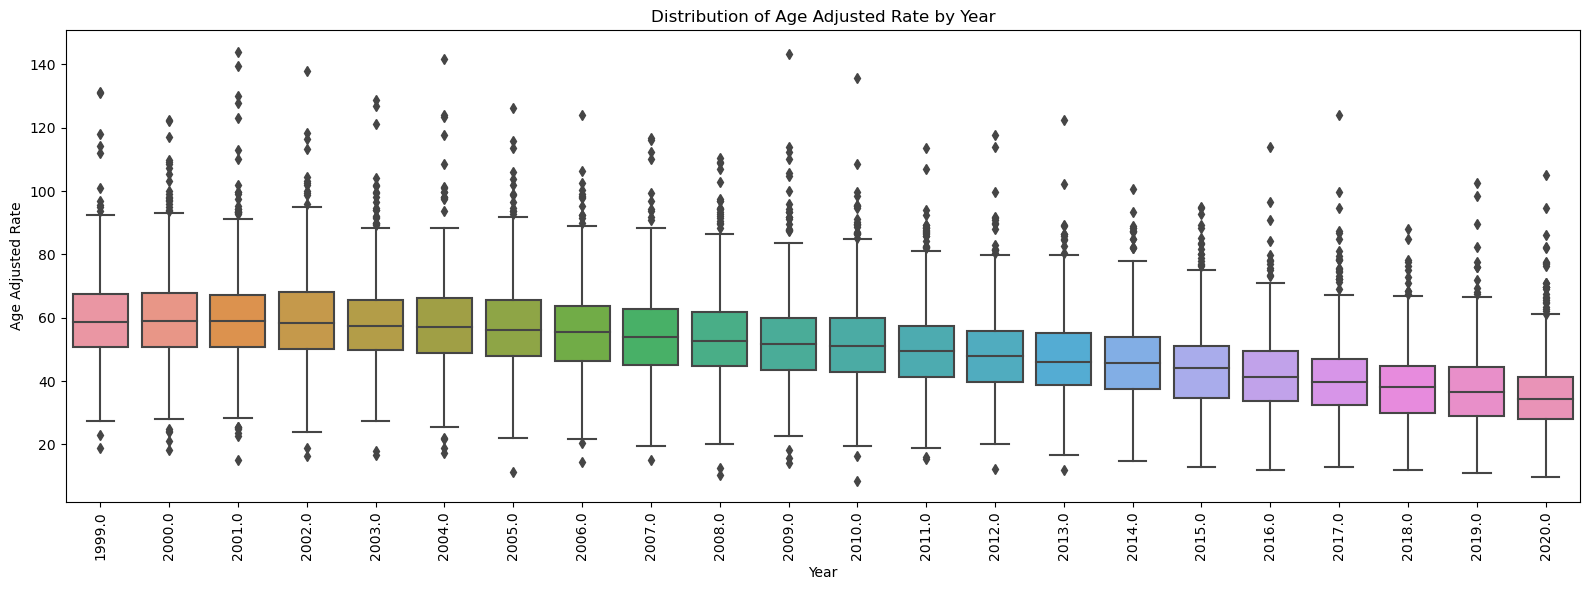

In [29]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_cancer, x="Year", y="Age Adjusted Rate")

plt.xticks(rotation=90)  
plt.title("Distribution of Age Adjusted Rate by Year")
plt.xlabel("Year")
plt.ylabel("Age Adjusted Rate")

plt.tight_layout()
plt.show()

In [6]:
len(df_cancer)

19213

# MLP Regression
Not using County as feature because it makes the data very sparse if doing one-hot coding.
- X: `["Days_PM25_fraction", "Unhealthy_fraction", "VeryUnhealthy_fraction", "Hazardous_fraction", "Max_AQI", "Median_AQI"]`
- y: `"Age Adjusted Rate"`
- Loss Function: MSE

## Step 1: Data Pre-processing

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
# sort the data by year
df_cancer = df_cancer.sort_values("Year").reset_index(drop=True)

In [8]:
# ignore any rows with NaN value
df_cancer = df_cancer[["Days_PM25_fraction", "Unhealthy_fraction", "VeryUnhealthy_fraction", 
                      "Hazardous_fraction", "Max_AQI", "Median_AQI", "Age Adjusted Rate"]]
df_cancer = df_cancer.dropna()
len(df_cancer)

16673

In [9]:
# get out X
X = df_cancer[["Days_PM25_fraction", "Unhealthy_fraction", "VeryUnhealthy_fraction", 
              "Hazardous_fraction", "Max_AQI", "Median_AQI"]].to_numpy()

# min-max scale X
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)

# add a bias term for X
Phi = np.column_stack((X_scale, np.ones(X_scale.shape[0])))
Phi[:5]

array([[1.        , 0.        , 0.        , 0.        , 0.00773908,
        0.22307692, 1.        ],
       [0.        , 0.15915153, 0.02853801, 0.        , 0.02133776,
        0.36923077, 1.        ],
       [0.23287671, 0.05263158, 0.02673973, 0.        , 0.02111664,
        0.36923077, 1.        ],
       [0.09641873, 0.02646078, 0.        , 0.        , 0.0199005 ,
        0.27692308, 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.01514649,
        0.32307692, 1.        ]])

In [10]:
# get out y
y = df_cancer["Age Adjusted Rate"].to_numpy().reshape(-1, 1)
y[:5]

array([[37.3],
       [77.6],
       [44.3],
       [56.9],
       [51.8]])

## Step 2-1: Shuffle Data & Seprate into Train, Validation, Test Sets (70-15-15)

In [8]:
np.random.seed(32)

def shuffle_data(X, y):
    idx = np.random.permutation(len(X))
    return X[idx], y[idx]

shuffled_X, shuffled_y = shuffle_data(Phi, y)

In [9]:
# seperate to train, val, test
n = len(shuffled_X)

train_end_idx = int(0.7 * n)
val_end_idx = int(0.85 * n)

X_train = shuffled_X[:train_end_idx]
y_train = shuffled_y[:train_end_idx]

X_val = shuffled_X[train_end_idx:val_end_idx]
y_val = shuffled_y[train_end_idx:val_end_idx]

X_test = shuffled_X[val_end_idx:]
y_test = shuffled_y[val_end_idx:]

## Step 2-2: No Shuffle; Split by Year

In [11]:
# training: 1999~2014
# validation: 2015~2017
# test: 2018~2020

train_end_idx = 12335
val_end_idx = 12335+2196

X_train = Phi[:train_end_idx]
y_train = y[:train_end_idx]

X_val = Phi[train_end_idx:val_end_idx]
y_val = y[train_end_idx:val_end_idx]

X_test = Phi[val_end_idx:]
y_test = y[val_end_idx:]

len(X_train)+len(X_val)+len(X_test)

16673

## Step 3: Implement MLP by Hand
1. Phi: (N, 7)
2. W1: (7, 32) + ReLU() --> h1: (N, 32)
3. W2: (32, 16) + ReLU() --> h2: (N, 16)
4. W3: (16, 1) + Linear() --> output: (N, 1)
5. Loss: MSE(y, output)

In [12]:
from tqdm import tqdm

In [13]:
# set random seed so the result would be the same every time
np.random.seed(12)

# define, choose, and initialize values
epochs = 3000
eta = 0.00003

q = 32
p = 16
W1 = np.random.randn(7,q)
W2 = np.random.randn(q,p)
W3 = np.random.randn(p,1)

In [14]:
def _relu_derivative(z):
    return (z > 0).astype(float)

In [15]:
def f(X):
    z1 = np.matmul(X, W1)
    h1 = np.maximum(0, z1)
    z2 = np.matmul(h1, W2)
    h2 = np.maximum(0, z2)
    y_hat = np.matmul(h2, W3)
    
    return z1, h1, z2, h2, y_hat

def dL_dW3(h2, diff, N):
    return 2 / N * (np.matmul(h2.T, (diff)))

def dL_dW2(h1, z2, diff, N):
    dLdh2 = np.matmul(diff, W3.T)
    dh2dz2 = _relu_derivative(z2)
    
    dLdz2 = dLdh2 * dh2dz2
    return 2 / N * np.matmul(h1.T, dLdz2)

def dL_dW1(z2, z1, diff, X, N):
    dLdh2 = np.matmul(diff, W3.T)
    dh2dz2 = _relu_derivative(z2)
    dLdz2 = dLdh2 * dh2dz2
    
    dh1dz1 = _relu_derivative(z1)
    
    dz2dz1 = np.matmul(dLdz2, W2.T) * dh1dz1
    
    return 2 / N * np.matmul(X.T, dz2dz1)

In [16]:
def train_pipeline(X_train, y_train, X_val, y_val, epochs, eta, batch_size=64):
    global W1, W2, W3
    
    ls_train_loss = []
    ls_val_loss = []
    
    for epoch in tqdm(range(epochs)):
        # mini-batch
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size]
            
            # forward
            z1, h1, z2, h2, y_hat = f(X_batch)
            
            # diff 
            diff = y_hat - y_batch
            N = len(X_batch)
            
            # calculate derivatives
            dW3 = dL_dW3(h2, diff, N)
            dW2 = dL_dW2(h1, z2, diff, N)
            dW1 = dL_dW1(z2, z1, diff, X_batch, N)
            
            # update weights
            W3 -= eta * dW3
            W2 -= eta * dW2
            W1 -= eta * dW1
            
        # calculate error to track every update
        _, _, _, _, y_hat1 = f(X_train)
        train_loss = np.mean((y_hat1 - y_train) ** 2)
        ls_train_loss.append(train_loss)

        # use validation set to track if overfitting
        _, _, _, _, y_hat2 = f(X_val)
        val_loss = np.mean((y_hat2 - y_val) ** 2)
        ls_val_loss.append(val_loss)

    return ls_train_loss, ls_val_loss


## Step 4: Start Training

In [17]:
import matplotlib.pyplot as plt

100%|███████████████████████████████████████| 3000/3000 [02:06<00:00, 23.79it/s]


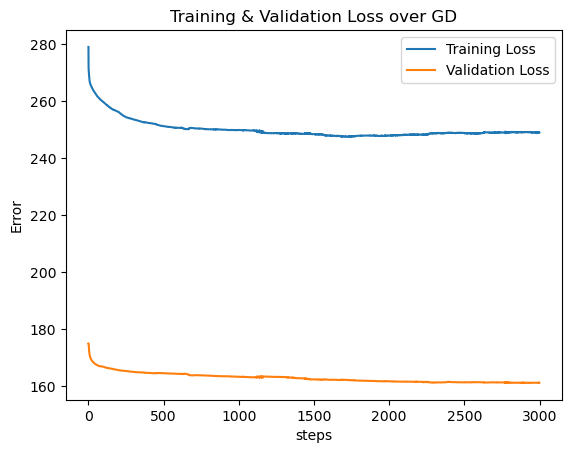

In [18]:
ls_train_loss, ls_val_loss = train_pipeline(X_train, y_train, X_val, y_val, epochs, eta, batch_size=32)

plt.plot(range(epochs), ls_train_loss, label='Training Loss')
plt.plot(range(epochs), ls_val_loss, label='Validation Loss')
plt.title('Training & Validation Loss over GD')
plt.xlabel('steps')
plt.ylabel('Error')
plt.legend()
plt.show()

## Step 5: Test the Model

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

In [20]:
# predict
_, _, _, _, y_pred = f(X_test)
y_pred = y_pred.reshape(-1, 1)

# evaluate accuracy
print("MSE: ", mean_squared_error(y_test, y_pred))
print("R^2: ", r2_score(y_test, y_pred))

MSE:  203.02567908615794
R^2:  -0.4595313416963993


# MLP Classification
Binarize lung cancer mortality into high (top 25% of counties per year) vs. low (bottom 75%)
## Step 1: Data Pre-processing

In [64]:
df_cancer = pd.read_csv("pollution_cancer.csv")
df_cancer = df_cancer.sort_values("Year").reset_index(drop=True)

In [65]:
# ignore any rows with NaN value
df_cancer = df_cancer[["Days_PM25_fraction", "Unhealthy_fraction", "VeryUnhealthy_fraction", 
                      "Hazardous_fraction", "Max_AQI", "Median_AQI", "Age Adjusted Rate", "Year", "County"]]
df_cancer = df_cancer.dropna()
len(df_cancer)

16673

In [66]:
# calculate 75th percentail grouped by year
df_cancer["threshold"] = df_cancer.groupby("Year")["Age Adjusted Rate"].transform(
    lambda x: x.quantile(0.5)
)

#  Assign binary labels (1 = high, 0 = low)
df_cancer["binary_risk"] = (df_cancer["Age Adjusted Rate"] >= df_cancer["threshold"]).astype(int)
df_cancer.head()

,Days_PM25_fraction,Unhealthy_fraction,VeryUnhealthy_fraction,Hazardous_fraction,Max_AQI,Median_AQI,Age Adjusted Rate,Year,County,threshold,binary_risk
0,1.000000,0.000000,0.000000,0.0,80,31,37.3,1999.0,"Burleigh County, ND",58.6,0
1,0.000000,0.049708,0.005848,0.0,203,50,77.6,1999.0,"Tehama County, CA",58.6,1
2,0.232877,0.016438,0.005479,0.0,201,50,44.3,1999.0,"Bronx County, NY",58.6,0
3,0.096419,0.008264,0.000000,0.0,190,38,56.9,1999.0,"Albany County, NY",58.6,0
4,0.000000,0.000000,0.000000,0.0,147,44,51.8,1999.0,"Valencia County, NM",58.6,0


In [67]:
# get out X
X = df_cancer[["Days_PM25_fraction", "Unhealthy_fraction", "VeryUnhealthy_fraction", 
              "Hazardous_fraction", "Max_AQI", "Median_AQI"]].to_numpy()

# min-max scale X
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)

# add a bias term for X
Phi = np.column_stack((X_scale, np.ones(X_scale.shape[0])))
Phi[:5]

array([[1.        , 0.        , 0.        , 0.        , 0.00773908,
        0.22307692, 1.        ],
       [0.        , 0.15915153, 0.02853801, 0.        , 0.02133776,
        0.36923077, 1.        ],
       [0.23287671, 0.05263158, 0.02673973, 0.        , 0.02111664,
        0.36923077, 1.        ],
       [0.09641873, 0.02646078, 0.        , 0.        , 0.0199005 ,
        0.27692308, 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.01514649,
        0.32307692, 1.        ]])

In [68]:
# get out y
y = df_cancer["binary_risk"].to_numpy().reshape(-1, 1)
y[:5]

array([[0],
       [1],
       [0],
       [0],
       [0]])

## Step 2: Shuffle Data & Seprate into Train, Validation, Test Sets (70-15-15)

In [69]:
np.random.seed(32)

def shuffle_data(X, y):
    idx = np.random.permutation(len(X))
    return X[idx], y[idx]

shuffled_X, shuffled_y = shuffle_data(Phi, y)

In [70]:
# seperate to train, val, test
n = len(shuffled_X)

train_end_idx = int(0.7 * n)
val_end_idx = int(0.85 * n)

X_train = shuffled_X[:train_end_idx]
y_train = shuffled_y[:train_end_idx]

X_val = shuffled_X[train_end_idx:val_end_idx]
y_val = shuffled_y[train_end_idx:val_end_idx]

X_test = shuffled_X[val_end_idx:]
y_test = shuffled_y[val_end_idx:]

## Step 2-2: No Shuffle; Split by Year

In [56]:
# training: 1999~2014
# validation: 2015~2017
# test: 2018~2020

train_end_idx = 12335
val_end_idx = 12335+2196

X_train = Phi[:train_end_idx]
y_train = y[:train_end_idx]

X_val = Phi[train_end_idx:val_end_idx]
y_val = y[train_end_idx:val_end_idx]

X_test = Phi[val_end_idx:]
y_test = y[val_end_idx:]

len(X_train)+len(X_val)+len(X_test)

16673

## Step 3: Implement MLP by Hand
1. Phi: (N, 7)
2. W1: (7, 32) + ReLU() --> h1: (N, 32)
3. W2: (32, 16) + ReLU() --> h2: (N, 16)
4. W3: (16, 1) + Sigmoid() --> output: (N, 1)
5. Loss: BCE (y, output)

In [57]:
def bce_loss(y, y_hat):
    eps = 1e-12  
    y_hat = np.clip(y_hat, eps, 1-eps)
    return -np.mean( y*np.log(y_hat) + (1-y)*np.log(1-y_hat) )

In [71]:
# set random seed so the result would be the same every time
np.random.seed(32)

# define, choose, and initialize values
epochs = 1000
eta = 0.00001

q = 32
p = 16
W1 = np.random.randn(7,q)
W2 = np.random.randn(q,p)
W3 = np.random.randn(p,1)

In [72]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def f(X):
    z1 = np.matmul(X, W1)          
    h1 = np.maximum(0, z1)     
    z2 = np.matmul(h1, W2)       
    h2 = np.maximum(0, z2)      
    z3 = np.matmul(h2, W3)         
    y_hat = sigmoid(z3)      
    
    return z1, h1, z2, h2, y_hat 

def dL_dW3(h2, diff, N):
    return (1.0 / N) * np.matmul(h2.T, diff)

def dL_dW2(h1, z2, diff, N):
    dLdh2 = np.matmul(diff, W3.T)  
    dh2dz2 = _relu_derivative(z2)    

    dLdz2 = dLdh2 * dh2dz2        
    return (1.0 / N) * np.matmul(h1.T, dLdz2)

def dL_dW1(z2, z1, diff, X, N):
    dLdh2 = np.matmul(diff, W3.T)      
    dh2dz2 = _relu_derivative(z2)
    dLdz2 = dLdh2 * dh2dz2          

    dh1dz1 = _relu_derivative(z1)    
    dz2dz1 = np.matmul(dLdz2, W2.T) * dh1dz1  

    return (1.0 / N) * np.matmul(X.T, dz2dz1) 


In [73]:
def train_pipeline(X_train, y_train, X_val, y_val, epochs, eta, batch_size=64):
    global W1, W2, W3
    
    ls_train_loss = []
    ls_val_loss = []
    
    for epoch in tqdm(range(epochs)):
        # mini-batch
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i : i + batch_size]
            y_batch = y_train[i : i + batch_size]
            
            # forward
            z1, h1, z2, h2, y_hat = f(X_batch)
            
            # diff 
            diff = y_hat - y_batch
            N = len(X_batch)
            
            # calculate derivatives
            dW3 = dL_dW3(h2, diff, N)
            dW2 = dL_dW2(h1, z2, diff, N)
            dW1 = dL_dW1(z2, z1, diff, X_batch, N)
            
            # update weights
            W3 -= eta * dW3
            W2 -= eta * dW2
            W1 -= eta * dW1
            
        # calculate error to track every update
        _, _, _, _, y_hat1 = f(X_train)
        train_loss = bce_loss(y_train, y_hat1)
        ls_train_loss.append(train_loss)

        # use validation set to track if overfitting
        _, _, _, _, y_hat2 = f(X_val)
        val_loss = bce_loss(y_val, y_hat2)
        ls_val_loss.append(val_loss)

    return ls_train_loss, ls_val_loss

## Step 4: Train the Model

100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.00it/s]


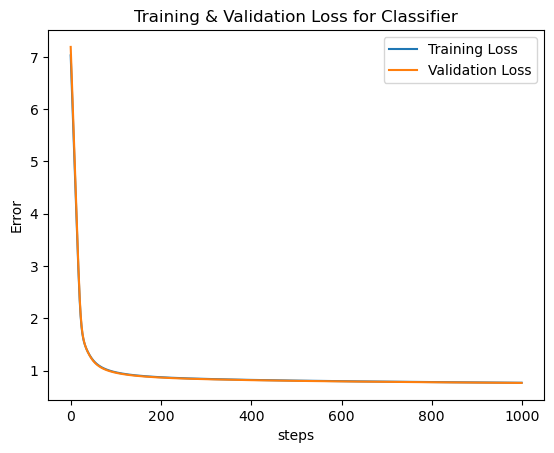

In [74]:
ls_train_loss, ls_val_loss = train_pipeline(X_train, y_train, X_val, y_val, epochs, eta, batch_size=64)

plt.plot(range(epochs), ls_train_loss, label='Training Loss')
plt.plot(range(epochs), ls_val_loss, label='Validation Loss')
plt.title('Training & Validation Loss for Classifier')
plt.xlabel('steps')
plt.ylabel('Error')
plt.legend()
plt.show()

## Step 5: Evaluate Accuracy

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [75]:
# predict probability
_, _, _, _, y_proba = f(X_test)   
y_proba = y_proba.reshape(-1)    

y_pred = (y_proba >= 0.5).astype(int)

y_true = y_test.reshape(-1).astype(int)

print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall   :", recall_score(y_true, y_pred))
print("F1-score :", f1_score(y_true, y_pred))

Accuracy : 0.49020391843262695
Precision: 0.4922879177377892
Recall   : 0.6123101518784972
F1-score : 0.5457784111150694
